<a href="https://colab.research.google.com/github/amarabuco/am-pos-2020-2/blob/main/Atividade_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 08 - Ensembles - Realizar a implementação do bagging, boosting e stacking para a base de dados do Glass

Realizar experimento com a implementação de comitês bagging, boosting e stacking para base de dados do Glass. Os modelos base para formação do comitê poderão ser KNN, SVM, Árvore de Decisão e/ou Redes Neurais Artificiais. Realizar uma busca de tal modo que os comitês apresentem desempenho superior ao desempenho solo dos classificadores. Apresentar análise, os principais desafios encontrados para a construção dos comitês e conclusões.

Entende-se por classificador ensemble (também chamado de comitê de learners, mistura de especialistas ou sistema de classificadores múltiplo), consiste em um conjunto de classificadores treinados individualmente, classificadores de base, cujas decisões são de alguma forma combinadas (Marques et al., 2012).

In [ ]:
!pip install -U mlens

     |████████████████████████████████| 235kB 6.0MB/s 


In [ ]:
import numpy as np
import pandas as pd

#pre-processing
from sklearn.preprocessing import StandardScaler


# cross validation
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

# gridsearch
from sklearn.model_selection import GridSearchCV, cross_validate, learning_curve

# models
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier

#ensembles
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from mlens.ensemble import SuperLearner
from xgboost import XGBClassifier

#dimensionality reduction
from sklearn.decomposition import PCA

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
cols = ["id","RI","Na","Mg","Al","Si","K","Ca","Ba","Fe","Type"]
glass = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data', sep=',', names=cols, index_col="id")

# Pré-processamento

Na etapa de pré-processamento foi feita a separação entre o conjuunto de treinamento e de teste, bem como a normalização dos dados de entrada dos modelos.

In [ ]:
glass.tail()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
id,,,,,,,,,,
210,1.51623,14.14,0.0,2.88,72.61,0.08,9.18,1.06,0.0,7
211,1.51685,14.92,0.0,1.99,73.06,0.00,8.40,1.59,0.0,7
212,1.52065,14.36,0.0,2.02,73.42,0.00,8.44,1.64,0.0,7
213,1.51651,14.38,0.0,1.94,73.61,0.00,8.48,1.57,0.0,7
214,1.51711,14.23,0.0,2.08,73.36,0.00,8.62,1.67,0.0,7


In [ ]:
X = glass[glass.columns[:-1]]
y = glass[glass.columns[-1]]

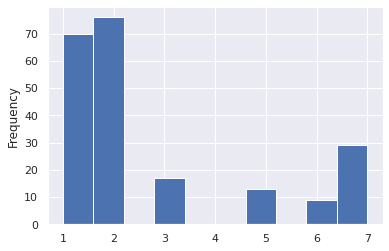

In [ ]:
y.plot.hist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=40, test_size=0.8)

In [ ]:
scaler = StandardScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
Xt_norm = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

# EDA

In [ ]:
pca = PCA(n_components=2, svd_solver='full')

In [ ]:
X_pca = pd.DataFrame(pca.fit_transform(X_norm), index=X_train.index)

In [ ]:
pca.explained_variance_ratio_

array([0.29399938, 0.20531257])

In [ ]:
train_pca = X_pca.join(y_train)
train_pca

,0,1,Type
id,,,
32,-0.726013,0.663606,1
164,5.575985,-2.316368,5
172,4.915642,-2.150096,5
88,-0.000666,0.370786,2
175,-0.635514,-2.267951,5
45,-1.198206,-0.143024,1
61,-0.922299,0.325026,1
31,-0.880001,0.116136,1
179,-0.127265,0.162008,6


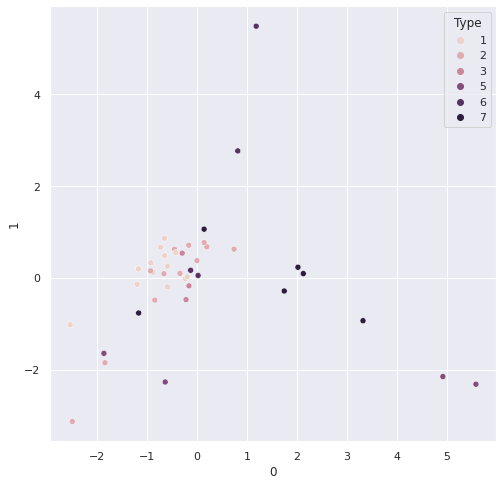

In [ ]:
fig = plt.subplots(figsize=(8,8))
sns.scatterplot(data=train_pca, x=0,y=1, hue='Type')

# Bagging

No Bagging os classificadores são treinados de forma independente por diferentes conjuntos de treinamento através do método de inicialização. Para construí-los é necessário montar k conjuntos de treinamento idênticos e replicar esses dados de treinamento de forma aleatória para construir k redes independentes por re-amostragem com reposição. Em seguida, deve-se agregar as k redes através de um método de combinação apropriada, tal como a maioria de votos (Breiman, 1996).

Para garantir que há amostras de treinamento suficientes em cada subconjunto, grandes porções de amostras (75-100%) são colocadas em cada subconjunto. Com isso, os subconjuntos individuais de formação se sobrepõem de forma significativa, com muitos casos fazendo parte da maioria dos subconjuntos e podendo até mesmo aparecer várias vezes num mesmo subconjunto. A fim de assegurar a diversidade de situações, um learner de base relativamente instável é usado para que limites de decisão diferentes possam ser obtidos, considerando-se pequenas perturbações em diferentes amostras de treinamento (Wang, 2011).


A construção do comitê bagging utilizou a class BaggingClassifier, e realizou-se em três etapas para cada um dos modelos base: tree, svm, knn e rna.

1. Criação e configuração do comitê
2. Validação cruzada (Treinamento x Validação)
3. Teste

In [ ]:
bag_clf_tree = BaggingClassifier(n_estimators=10, random_state=5)
bag_cv_tree = pd.DataFrame(cross_validate(bag_clf_tree, X_norm, y_train, cv=5, return_train_score=True))
bag_clf_tree.fit(X_norm, y_train)
bag_pred_tree = bag_clf_tree.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
bag_clf_svm = BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=5)
bag_cv_svm = pd.DataFrame(cross_validate(bag_clf_svm, X_norm, y_train, cv=5, return_train_score=True))
bag_clf_svm.fit(X_norm, y_train)
bag_pred_svm = bag_clf_svm.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
bag_clf_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(),
                        n_estimators=10, random_state=5)
bag_cv_knn = pd.DataFrame(cross_validate(bag_clf_knn, X_norm, y_train, cv=5, return_train_score=True))
bag_clf_knn.fit(X_norm, y_train)
bag_pred_knn = bag_clf_knn.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
bag_clf_rna = BaggingClassifier(base_estimator=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=800,),
                        n_estimators=10, random_state=5)
bag_cv_rna = pd.DataFrame(cross_validate(bag_clf_rna, X_norm, y_train, cv=5, return_train_score=True))
bag_clf_rna.fit(X_norm, y_train)
bag_pred_rna = bag_clf_rna.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


## Resultados da Validação Cruzada

In [ ]:
cv_bagging_mean = pd.DataFrame({'tree': bag_cv_tree.mean(), 'svm': bag_cv_svm.mean(), 'knn': bag_cv_knn.mean(), 'rna': bag_cv_rna.mean()})

In [ ]:
cv_bagging_mean

,tree,svm,knn,rna
fit_time,0.017649,0.019599,0.012388,0.725184
score_time,0.002458,0.003073,0.007367,0.003550
test_score,0.466667,0.333333,0.308333,0.505556
train_score,0.976114,0.696435,0.547059,0.904456


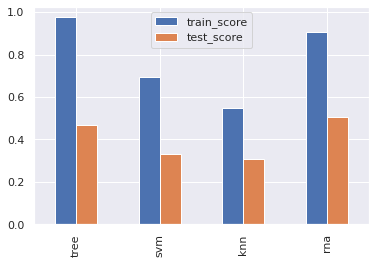

In [ ]:
cv_bagging_mean.loc[['train_score','test_score']].T.plot.bar()

In [ ]:
cv_bagging_std = pd.DataFrame({'tree': bag_cv_tree.std(), 'svm': bag_cv_svm.std(), 'knn': bag_cv_knn.std(), 'rna': bag_cv_rna.std()})

In [ ]:
cv_bagging_std

,tree,svm,knn,rna
fit_time,0.002154,0.003308,0.002600,0.170075
score_time,0.000179,0.001095,0.001141,0.000080
test_score,0.227074,0.093686,0.157870,0.176394
train_score,0.013360,0.049127,0.050368,0.033947


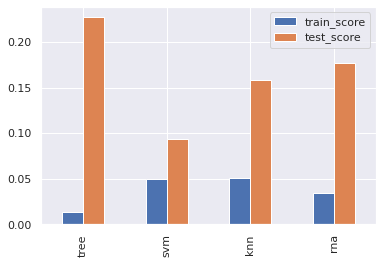

In [ ]:
cv_bagging_std.loc[['train_score','test_score']].T.plot.bar()

* A análise da acurácia média dos comitês bagging evidenciou a ocorrência do overfitting em todos os modelos, pois há uma grande perda de performance no conjunto de validação em relação ao treinamento, especialment nos casos do comitê de árvores de decisão e redes neurais, que atingiram mais 90% no treinamento e menos de 51% do conjunto de validação. Sendo o comitê de redes neurais, o que obteve a melhor acurácia do quatro modelos base testados.

* A análise do desvio padrão revela que o comitê de árvores de decisão e redes neurais apresentaram uma grande variância no conjunto de validação quando comparado ao conjunto de treinamento, o que indica que tais modelos são mais sensíveis aos dados recebidos no treinamento, acarretando maior instabilidade na construção dos comitês, do que os comitês de knn e svm.

## Resultados do Teste

In [ ]:
pred_bagging = pd.DataFrame({'tree': bag_pred_tree, 'svm': bag_pred_svm, 'knn': bag_pred_knn, 'rna': bag_pred_rna})

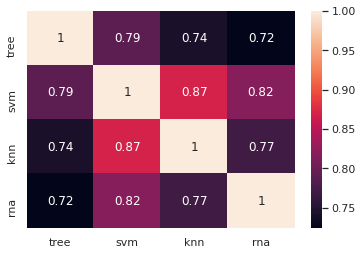

In [ ]:
sns.heatmap(pred_bagging.corr(), annot=True)

In [ ]:
pred_bagging_score = pd.Series({'tree': accuracy_score(y_test, bag_pred_tree), 'svm': accuracy_score(y_test, bag_pred_svm), 'knn': accuracy_score(y_test, bag_pred_knn), 'rna': accuracy_score(y_test, bag_pred_rna)})

In [ ]:
pred_bagging = pd.Series({'tree': f1_score(y_test, bag_pred_tree, average='micro'), 'svm': f1_score(y_test, bag_pred_svm, average='micro'), 'knn': f1_score(y_test, bag_pred_knn, average='micro'), 'rna': f1_score(y_test, bag_pred_rna, average='micro')})

Text(0.5, 1.0, 'Classes x Models')

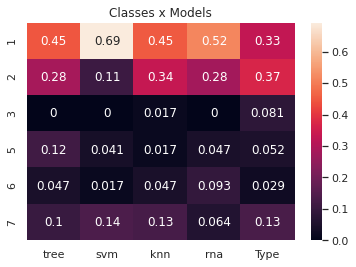

In [ ]:
classes = {}
pred_bagging_hm = pred_bagging.set_index(y_test.index).join(y_test)
for col in pred_bagging_hm.columns:
  classes[col] = pred_bagging_hm[col].value_counts(normalize=True)
sns.heatmap(pd.DataFrame(classes).fillna(0),annot=True).set_title('Classes x Models')


In [ ]:
pred_bagging_score

tree    0.639535
svm     0.563953
knn     0.639535
rna     0.575581
dtype: float64

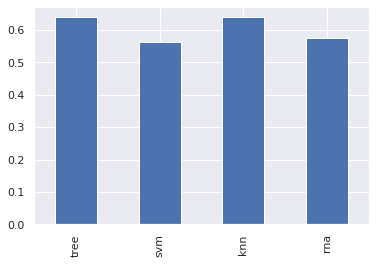

In [ ]:
pred_bagging_score.plot.bar()

* A acurácia média da previsão no conjunto de teste apresentou resultados distintos da validação cruzada. As métricas dos diferentes comitês foram semelhantes entre 56% - 63%, diferente dos resultados da validação cruzada que foram díspares. Além disso, o comitê de KNN teve um resultado melhor que o de rede neural, igualando com a acurácia das árvores de decisão. A análise da correlação entre as previsões dos comitês indica que eles possuem alta correlação entre si.

In [ ]:
report = {}
for pred in pred_bagging:
  report[pred] = classification_report(y_test, pred_bagging[pred], output_dict=True)['weighted avg']
report = pd.DataFrame(report)
report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,tree,svm,knn,rna
precision,0.628349,0.582398,0.622678,0.584600
recall,0.639535,0.563953,0.639535,0.575581
f1-score,0.617410,0.493330,0.614312,0.549580
support,172.000000,172.000000,172.000000,172.000000


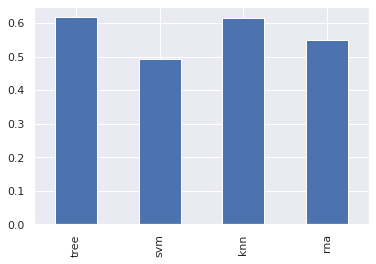

In [ ]:
report.T['f1-score'].plot.bar()

A análise do f1-score revelou resultados semelhantes para o knn e tree, enquanto o svm obteve um pior desempenho em virtude do viés para classe 1.

In [ ]:
# learning curve
"""
train_sizes, train_scores, valid_scores = learning_curve(
    BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=5), X, y, cv=5)
"""

'\ntrain_sizes, train_scores, valid_scores = learning_curve(\n    BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=5), X, y, cv=5)\n'

# Voting 

Um Classificador Voting é um modelo de aprendizado de máquina que treina em um conjunto de inúmeros modelos e prevê uma saída com base em sua maior probabilidade de classe escolhida como a saída.
Ele agrega os resultados de cada classificador aprovado no Classificador de Votação e prevê a classe de saída com base na maior maioria dos votos. A ideia é, em vez de criar modelos dedicados separados e encontrar a precisão para cada um deles, criamos um único modelo que treina por esses modelos e prevê a saída com base em sua maioria combinada de votação para cada classe de saída.

A construção do comitê de voto majoritário utilizou a class VotingClassifier, e combinou os quatros comitê bagging usando o voto soft, cuja regra de decisão é a soma das probabilidades das previsões.

In [ ]:
eclf1 = VotingClassifier(estimators=[('tree',BaggingClassifier(n_estimators=10, random_state=5)),('svm',BaggingClassifier(base_estimator=svm.SVC(), n_estimators=10, random_state=5)),('knn',BaggingClassifier(base_estimator=KNeighborsClassifier(),
                        n_estimators=10, random_state=5)),('rna',BaggingClassifier(base_estimator=MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=800,),
                        n_estimators=10, random_state=5))], voting='soft')
eclf1.fit(X_norm,y_train)

VotingClassifier(estimators=[('tree',
                              BaggingClassifier(base_estimator=None,
                                                bootstrap=True,
                                                bootstrap_features=False,
                                                max_features=1.0,
                                                max_samples=1.0,
                                                n_estimators=10, n_jobs=None,
                                                oob_score=False, random_state=5,
                                                verbose=0, warm_start=False)),
                             ('svm',
                              BaggingClassifier(base_estimator=SVC(C=1.0,
                                                                   break_ties=False,
                                                                   cache_size=200,
                                                                   class_weight=None,
                     

In [ ]:
accuracy_score(y_test,eclf1.predict(Xt_norm))

0.7209302325581395

O uso do voto majoritário soft combinando os comitês bagging levou a uma melhora na performance do melhor comitê bagging de 63% para 72% de acurácia no conjunto de teste.

# Boosting

No Boosting, de forma semelhante ao Bagging, cada classificador é treinado usando um conjunto de treinamento diferente. A abordagem por Boosting original foi proposta por Schapire em 1990. A principal diferença em relação ao Bagging é que os conjuntos de dados re-amostrados são construídos especificamente para gerar aprendizados complementares e a importância do voto é ponderado com base no desempenho de cada modelo, em vez da atribuição de mesmo peso para todos os votos. Essencialmente, esse procedimento permite aumentar o desempenho de um limiar arbitrário simplesmente adicionando learners mais fracos. Dada a utilidade desse achado, Boosting é considerado uma das descobertas mais significativas em aprendizado de máquina (LANTZ, 2013).

A construção do comitê boosting utilizou as classes AdaBoostClassifier, GradientBoostingClassifier e HistGradientBoostingClassifier, e o ExtremeGadrientBoostingClassifier do framework xgboost e realizou-se em três etapas.

1. Criação e configuração do comitê
2. Validação cruzada (Treinamento x Validação)
3. Teste

In [ ]:
%time
bst_clf_ada = AdaBoostClassifier(n_estimators=100, random_state=4)
bst_cv_ada = pd.DataFrame(cross_validate(bst_clf_ada, X_norm, y_train, cv=5, return_train_score=True))
bst_clf_ada.fit(X_norm, y_train)
bst_pred_ada = bst_clf_ada.predict(Xt_norm)          

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
%time
bst_clf_gb = GradientBoostingClassifier()
bst_cv_gb = pd.DataFrame(cross_validate(bst_clf_gb, X_norm, y_train, cv=5, return_train_score=True))
bst_clf_gb.fit(X_norm, y_train)
bst_pred_gb = bst_clf_gb.predict(Xt_norm)             

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
%time
bst_clf_hist = HistGradientBoostingClassifier(max_iter=100)
bst_cv_hist = pd.DataFrame(cross_validate(bst_clf_hist, X_norm, y_train, cv=5, return_train_score=True))
bst_clf_hist.fit(X_norm, y_train)
bst_pred_hist = bst_clf_hist.predict(Xt_norm)             

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
%time
bst_clf_xgb = XGBClassifier(n_estimators=100, random_state=4)
bst_cv_xgb = pd.DataFrame(cross_validate(bst_clf_xgb, X_norm, y_train, cv=5, return_train_score=True))
bst_clf_xgb.fit(X_norm, y_train)
bst_pred_xgb = bst_clf_xgb.predict(Xt_norm)          

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


## Resultados da Validação Cruzada

In [ ]:
cv_boosting_mean = pd.DataFrame({'ada': bst_cv_ada.mean(), 'gb': bst_cv_gb.mean(), 'xgb': bst_cv_xgb.mean(), 'hist': bst_cv_hist.mean()})

In [ ]:
cv_boosting_mean

,ada,gb,xgb,hist
fit_time,0.138436,0.315500,0.056765,0.060385
score_time,0.017105,0.001589,0.001844,0.008963
test_score,0.375000,0.538889,0.444444,0.308333
train_score,0.534759,1.000000,1.000000,0.309447


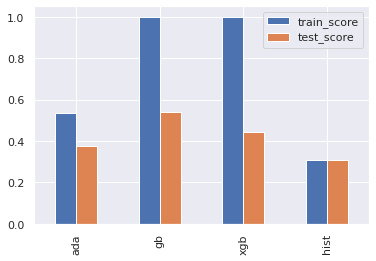

In [ ]:
cv_boosting_mean.loc[['train_score','test_score']].T.plot.bar()

In [ ]:
cv_boosting_std = pd.DataFrame({'ada': bst_cv_ada.std(), 'gb': bst_cv_gb.std(), 'xgb': bst_cv_xgb.std(), 'hist': bst_cv_hist.std()})

In [ ]:
cv_boosting_std

,ada,gb,xgb,hist
fit_time,0.007631,0.013509,0.042552,0.006361
score_time,0.005526,0.000045,0.000049,0.000256
test_score,0.131028,0.199923,0.165214,0.055902
train_score,0.094068,0.000000,0.000000,0.013360


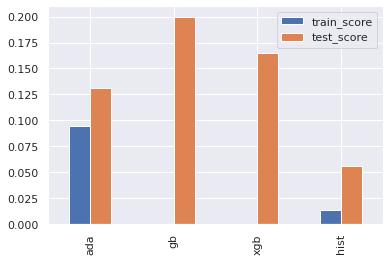

In [ ]:
cv_boosting_std.loc[['train_score','test_score']].T.plot.bar()

* A análise da acurácia média indicou a ocorrência de overfitting no caso gradientboosting e extremegradientboosting, pois os comitês obtiveram 100% acurácia no conjunto de treinamento e no de validação reduziu-se para 53% e 44%. Esse é um problema comum ao se utilizar árvores de decisão, que é estimador base dos comitês boosting utilizados. O desempenho do adaboosting e histgradientboosting foi próximo no conjunto de validação. Curioso notar que no hisgradientboosting a performance foi idêntica no treinamento e validação.
* A análise do desvio padrão em virtude do overfitting registrou variância zero no gradientboosting no conjunto de treinamento, enquanto na validação foi o maior desvio dentre os três comitês avaliados, e o menor desvio na validação foi do histgradientboosting.

## Resultados do Teste

In [ ]:
pred_boosting = pd.DataFrame({'ada': bst_pred_ada, 'gb': bst_pred_gb, 'xgb': bst_pred_xgb, 'hist':  bst_pred_hist})

Text(0.5, 1.0, 'Correlation Models')

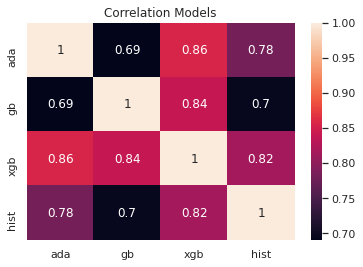

In [ ]:
sns.heatmap(pred_boosting.corr(), annot=True).set_title('Correlation Models')

In [ ]:
pred_boosting_score = pd.Series({'ada': accuracy_score(y_test, bst_pred_ada), 'gb': accuracy_score(y_test, bst_pred_gb), 'xgb': accuracy_score(y_test, bst_pred_xgb), 'hist': accuracy_score(y_test, bst_pred_hist)})

In [ ]:
pred_boosting_f1_score = pd.Series({'ada': f1_score(y_test, bst_pred_ada, average='micro'), 'gb': f1_score(y_test, bst_pred_gb, average='micro'), 'xgb': f1_score(y_test, bst_pred_xgb, average='micro'), 'hist': f1_score(y_test, bst_pred_hist, average='micro')})

Text(0.5, 1.0, 'Classes x Models')

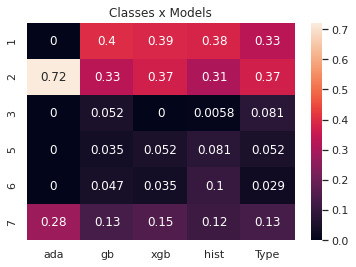

In [ ]:
classes = {}
pred_boosting_hm = pred_boosting.set_index(y_test.index).join(y_test)
for col in pred_boosting_hm.columns:
  classes[col] = pred_boosting_hm[col].value_counts(normalize=True)
sns.heatmap(pd.DataFrame(classes).fillna(0),annot=True).set_title('Classes x Models')


In [ ]:
pred_boosting_score

ada     0.430233
gb      0.686047
xgb     0.720930
hist    0.639535
dtype: float64

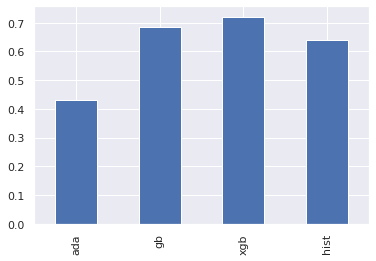

In [ ]:
pred_boosting_score.plot.bar()

No conjunto de teste o modelo **extremegradientboosting obteve a melhor performance**, enquanto no caso do adaboosting sua performance foi inferior ao histgradientboosting, invertendo a posição obtida no conjunto de validação. Analisando a correlação entre as previsões dos comitês, observa-se que possuem alta correlação entre si.

In [ ]:
pred_boosting_f1_score

ada     0.430233
gb      0.686047
xgb     0.720930
hist    0.639535
dtype: float64

In [ ]:
report = {}
for pred in pred_boosting:
  report[pred] = classification_report(y_test, pred_boosting[pred], output_dict=True)['weighted avg']
report = pd.DataFrame(report)
report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ada,gb,xgb,hist
precision,0.217328,0.670895,0.661410,0.632669
recall,0.430233,0.686047,0.720930,0.639535
f1-score,0.288708,0.672847,0.688889,0.625802
support,172.000000,172.000000,172.000000,172.000000


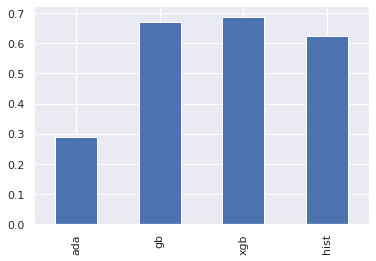

In [ ]:
report.T['f1-score'].plot.bar()

A análise do f1-score revelou a pontuação do xgb foi próxima a do gb, enquanto a pontuação do adaboosting foi bastante reduzida em relação a acurácia, em virtude do desbalanceamento das previsões que só apontaram as classes 2 e 7, ignorando as demais classes.

# Stacking

O stacking consiste em empilhar a saída do estimador individual e usar um classificador para calcular a previsão final. O empilhamento permite usar a força de cada estimador individual usando sua saída como entrada de um estimador final. É uma técnica de aprendizagem de conjunto para combinar múltiplos modelos de classificação através de um metaclassificador. Os modelos de classificação individual são treinados com base no conjunto completo de treinamento; em seguida, o metaclassificador é montado com base nas saídas - meta-características - dos modelos de classificação individual no conjunto. O meta-classificador pode ser treinado nos rótulos de classe previstos ou probabilidades do conjunto.

A construção do comitê stacking utilizou a class StackingClassifier e ensemble do framework ML-Ensemble, e realizou-se em três etapas usando os modelos base: tree, svm, knn e rna.

1. Criação e configuração do comitê
2. Validação cruzada (Treinamento x Validação)
3. Teste

## StackingClassifier

In [ ]:
estimators = [
    ('rna', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=800)),
    ('knn', KNeighborsClassifier()),
    ('tree', DecisionTreeClassifier())
]

In [ ]:
stk_clf_sk = StackingClassifier(
    estimators=estimators, final_estimator=svm.SVC(random_state=42))
stk_cv_sk = pd.DataFrame(cross_validate(stk_clf_sk, X_norm, y_train, cv=5, return_train_score=True))
stk_clf_sk.fit(X_norm, y_train)
stk_pred_sk = stk_clf_sk.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

In [ ]:
stk_cv_sk.mean()

fit_time       0.398337
score_time     0.003468
test_score     0.261111
train_score    0.641533
dtype: float64

In [ ]:
metrics.accuracy_score(y_test,stk_pred_sk)

0.5523255813953488

In [ ]:
estimators2 = [
    ('rna', MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=800)),
    ('svm',svm.SVC(random_state=42)),
    ('tree', DecisionTreeClassifier())
]

In [ ]:
stk_clf_sk2 = StackingClassifier(
    estimators=estimators2, final_estimator=KNeighborsClassifier())
stk_cv_sk2 = pd.DataFrame(cross_validate(stk_clf_sk2, X_norm, y_train, cv=5, return_train_score=True))
stk_clf_sk2.fit(X_norm, y_train)
stk_pred_sk2 = stk_clf_sk2.predict(Xt_norm)             

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in 

In [ ]:
stk_cv_sk2.mean()

fit_time       0.377539
score_time     0.005160
test_score     0.361111
train_score    0.475223
dtype: float64

In [ ]:
metrics.accuracy_score(y_test,stk_pred_sk2)

0.5

### Resultados do teste

In [ ]:
pred_stacking = pd.DataFrame({'svm': stk_pred_sk, 'knn': stk_pred_sk2})

Text(0.5, 1.0, 'Correlation Models')

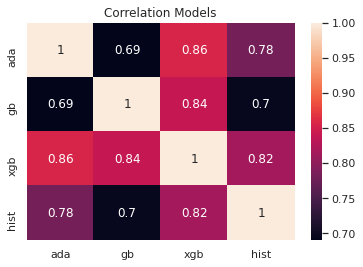

In [ ]:
sns.heatmap(pred_boosting.corr(), annot=True).set_title('Correlation Models')

Text(0.5, 1.0, 'Classes x Models')

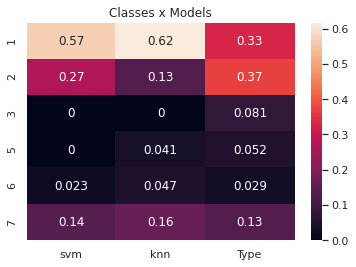

In [ ]:
classes = {}
pred_stacking_hm = pred_stacking.set_index(y_test.index).join(y_test)
for col in pred_stacking_hm.columns:
  classes[col] = pred_stacking_hm[col].value_counts(normalize=True)
sns.heatmap(pd.DataFrame(classes).fillna(0),annot=True).set_title('Classes x Models')

In [ ]:
pred_stacking_score = pd.Series({'svm': accuracy_score(y_test, stk_pred_sk), 'knn': accuracy_score(y_test, stk_pred_sk2)})

In [ ]:
pred_stacking_score

svm    0.552326
knn    0.500000
dtype: float64

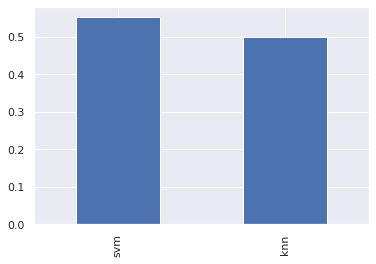

In [ ]:
pred_stacking_score.plot.bar()

Foram feitos diversas simulações para definir qual seria o melhor estimador final da stack.
* No conjunto de validação foi o KNN, 
* No conjunto de teste foi o SVM.

In [ ]:
report = {}
for pred in pred_stacking:
  report[pred] = classification_report(y_test, pred_stacking[pred], output_dict=True)['weighted avg']
report = pd.DataFrame(report)
report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,svm,knn
precision,0.487278,0.501379
recall,0.552326,0.500000
f1-score,0.498247,0.441979
support,172.000000,172.000000


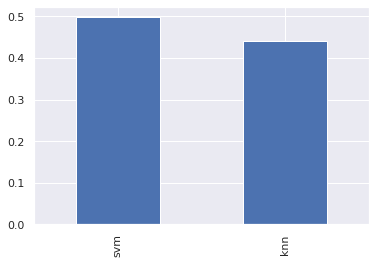

In [ ]:
report.T['f1-score'].plot.bar()

A análise do f1-score revelou resultados semelhantes aos da acurácia, haja vista que as previsões foram consideraram as diferentes classes e em proporções próximas entre os dois comitês.

## ML-Ensemble

In [ ]:
#ensemble = SuperLearner(scorer=accuracy_score, random_state=42, verbose=2)
ensemble = SuperLearner( random_state=42, verbose=2)
# Build layers
ensemble.add(MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1, max_iter=800)),
ensemble.add(KNeighborsClassifier()),
ensemble.add(DecisionTreeClassifier()),

# Attach the final meta estimator
ensemble.add_meta(svm.SVC())

#stk_cv_ml = pd.DataFrame(cross_validate(ensemble, X_norm, y_train, cv=5, return_train_score=True))
ensemble.fit(X_norm, y_train)
stk_pred_ml = ensemble.predict(Xt_norm)             


Fitting 4 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Processing layer-4             done | 00:00:00
Fit complete                        | 00:00:00

Predicting 4 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Processing layer-4             done | 00:00:00
Predict complete                    | 00:00:00


In [ ]:
metrics.accuracy_score(y_test, stk_pred_ml)

0.3313953488372093

Utilizou-se o framework ML-ensemble para construir comitês stacking mais complexos com múltiplas camadas.

Os resultados obtidos indicam que o uso de múltiplas camadas tende a aumentar o viés dos classificadores, levando ao underfitting.

Assim, como nos modelos de aprendizado profundo a arquitetura da rede deve ser configurada para que o modelo possa apresentar bons resultados, sendo este tipo de comitê mais suceptível a falhas de implementação do que os demais.

REFERÊNCIAS 

[Breiman(1996)] Breiman, L., 1996. Bagging Predictors. Machine Learning 24 (2), 123–140.

[Lantz(2013)] Lantz, B., 2013. Machine Learning with R. Packt Publishing Ltd.

[Marques et al.(2012)] Marques, A., Garcia, V., Sanchez, J., Sep 2012. Exploring the behaviour of base classifiers in credit scoring ensembles. Expert Systems with Applications 39 (11), 10244–10250.

[Schapire(1990)] Schapire, R. E., Jun 1990. http://dx.doi.org/10.1007/BF00116037 The strength of weak learnability. Mach Learn 5 (2), 197–227.

[Tsai et al.(2014) Tsai, Hsu, and Yen] Tsai, C.-F., Hsu, Y.-F., Yen, D. C., Nov 2014. A comparative study of classifier ensembles for bankruptcy prediction. Applied Soft Computing 24, 977–984.

[Wang et al.(2011) Wang, Hao, Ma, and Jiang] Wang, G., Hao, J., Ma, J., Jiang, H., Jan 2011. A comparative assessment of ensemble learning for credit scoring. Expert Systems with Applications 38 (1), 223–230.